<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/augmentation/mixup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MixUp: Augmentacja danych
##Import bibliotek

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

##Przygotowanie danych

In [21]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype('float32') / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

##Hiperparametry

In [22]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10

##Konwersja danych do obiektów TensorFlow Dataset

In [23]:
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)

train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)

train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

##Definicja techniki mixup

In [24]:
def sample_beta_distribution(size, concentration_0, concentration_1):
  gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
  gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
  return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

def mix_up(ds_one, ds_two, alpha=0.2):
  images_one, labels_one = ds_one
  images_two, labels_two = ds_two
  batch_size = tf.shape(images_one)[0]

  l = sample_beta_distribution(batch_size, alpha, alpha)
  x_l = tf.reshape(l, (batch_size, 1, 1, 1))
  y_l = tf.reshape(l, (batch_size, 1))

  images = images_one * x_l + images_two * (1 - x_l)
  labels = labels_one * y_l + labels_two * (1 - y_l)
  return (images, labels)

##Wizualizacja nowych danych po augmentacji

[0.0, 0.0, 0.5543097853660583, 0.0, 0.0, 0.0, 0.0, 0.0, 0.44569021463394165, 0.0]
[0.42582255601882935, 0.5741774439811707, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009788990020751953, 0.990211009979248]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.48884326219558716, 0.0, 0.0, 0.5111567378044128]
[0.9999998807907104, 0.0, 9.95695828009957e-08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0010974555043503642, 0.9989025592803955, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.2573114335536957, 0.0, 0.7426885366439819, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.02159716561436653, 0.0, 0.0, 0.0, 0.0, 0.978402853012085]


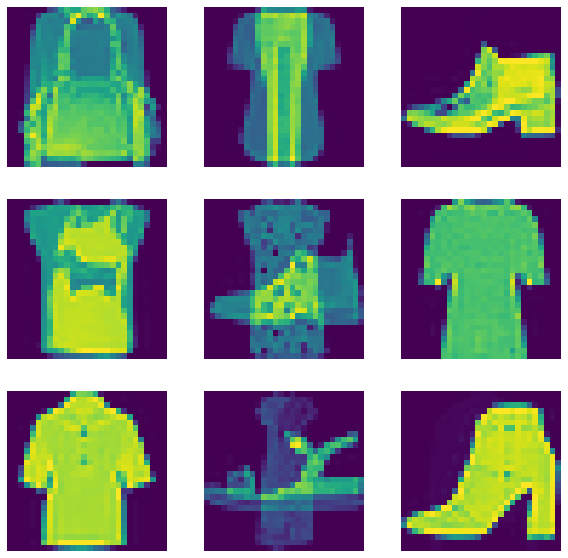

In [25]:
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), 
    num_parallel_calls=AUTO
)

sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img.numpy().squeeze())
  print(label.numpy().tolist())
  plt.axis('off')